In [1]:
import rasterio
from rasterio import plot
import numpy as np

import matplotlib.pyplot as plt


import datacube
import xarray as xr


%matplotlib inline

Sentinel's scene classification map gives the followning classes: 

<img src="./notebookImages/ClassificationClasses.jpg" alt="Classification Classes" style="width: 300px; height=500;"/>


In [2]:
dc = datacube.Datacube(app="NDVI")

ds = dc.load(
    product ="s2_sen2cor_ard_granule_EO3", 
    #longitude=(-73.90502929687499,-73.311767578125), 
    #latitude=(4.839207001225759, 5.916580744756599),
    time=("2020-08-01", "2020-08-02"),
    measurements=['red', 'green', 'blue', 'nir', 'scl'],
    output_crs='EPSG:32618',
    resolution=(-20,20),
    resampling='cubic'
)

In [3]:
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 5490, y: 10491)
Coordinates:
  * time         (time) datetime64[ns] 2020-08-01T20:56:40
  * y            (y) float64 7e+05 7e+05 7e+05 ... 4.902e+05 4.902e+05 4.902e+05
  * x            (x) float64 6e+05 6e+05 6.000e+05 ... 7.098e+05 7.098e+05
    spatial_ref  int32 32618
Data variables:
    red          (time, y, x) uint16 274 340 480 482 527 463 444 ... 0 0 0 0 0 0
    green        (time, y, x) uint16 505 614 758 721 794 784 765 ... 0 0 0 0 0 0
    blue         (time, y, x) uint16 262 314 385 379 422 387 383 ... 0 0 0 0 0 0
    nir          (time, y, x) uint16 3150 3763 3864 3803 3877 3966 ... 0 0 0 0 0
    scl          (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32618
    grid_mapping:  spatial_ref

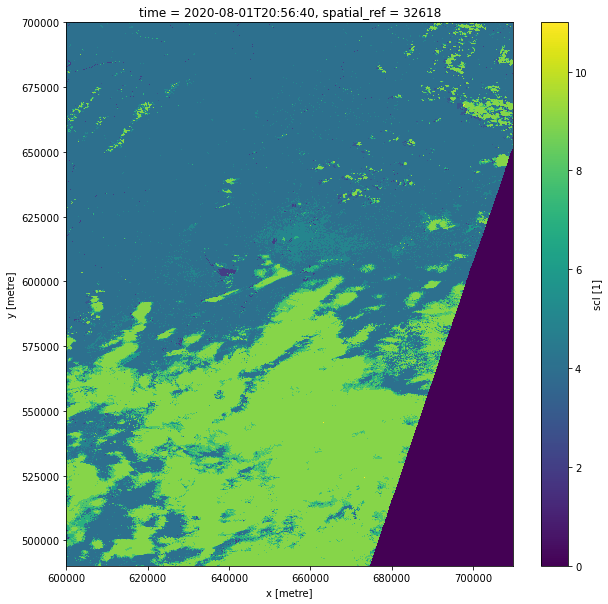

In [4]:
plt.figure(figsize=(10, 10))
#fig, axes = plt.subplots(1,2, figsize=(15,5))

ds.scl.plot()

#ds.nir[0].plot(ax = axes[1])

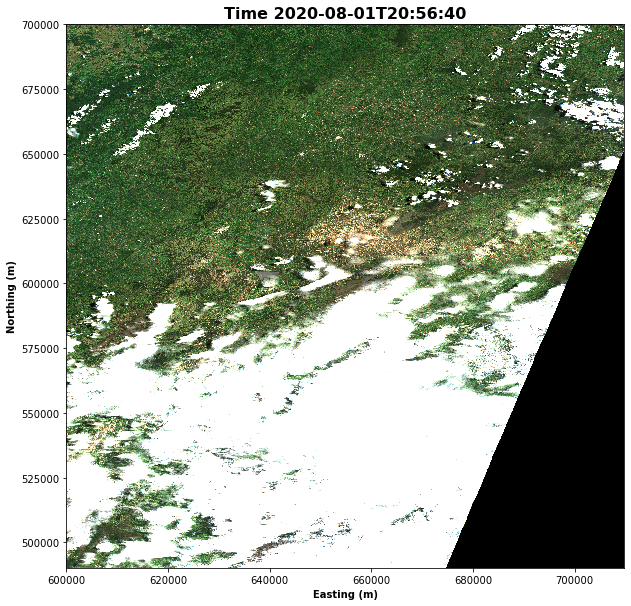

In [8]:
# Set the time step to view
time_index = 0

# Set the band combination to plot

bands = ["red", "green", "blue"]

# Format the time stamp for use as the plot title
time_string = str(ds.time.isel(time=time_index).values).split('.')[0]  

ds[bands].isel(time=time_index).to_array().plot.imshow(vmin=0,vmax=1500,figsize=(10,10))

# Set the title and axis labels
ax = plt.gca()

ax.set_title(f"Time {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

In [6]:
def cloud_mask(band,pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    
    Args:
        band (xarray.DataArray): Banda o respuesta espectral (red,blue,green,etc).
        pixel_qa (xarray.DataArray): The pixel quality band.
        
    Returns:
        xarray.DataArray: Matrix donde las nubes ha sido removidas (nodata). 
    """
    
    nodata=0
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    valid_values = [2, 3, 4, 5, 6]

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band,np.nan)
    return new_band_data_array

In [7]:
ds.red.values = cloud_mask(ds.red,ds.scl)
ds.nir.values = cloud_mask(ds.nir,ds.scl)


In [8]:
def ndvi(red,nir):
    """Indice de Vegetación Normalizado.
    
    Args:
        red (xarray.DataArray): Banda red .
        nir (xarray.DataArray): Banda nir.
        
    Returns:
        xarray.DataArray: Matr
    """
    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = red.values
    period_nir = nir.values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array

<Figure size 720x720 with 0 Axes>

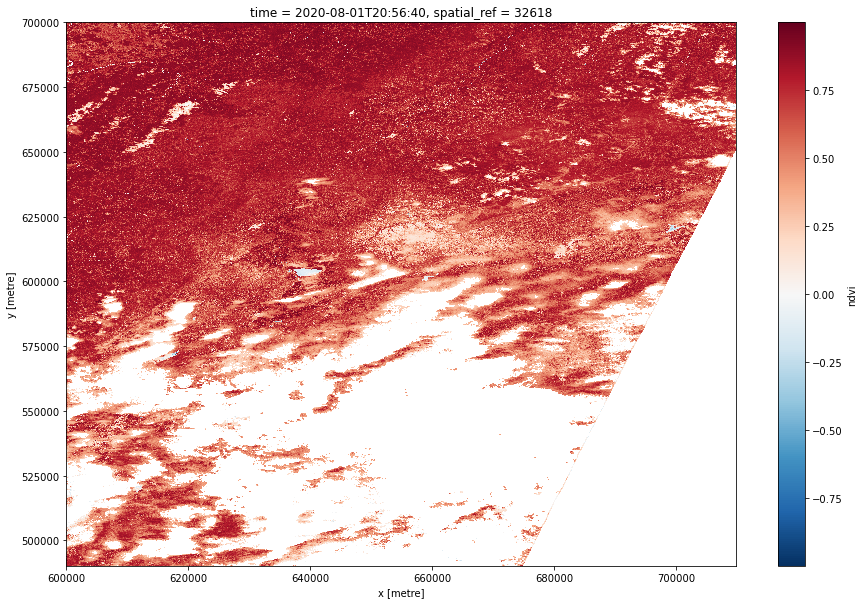

In [12]:
mask_nan=np.logical_or(np.isnan(ds.red.values), np.isnan(ds.nir.values))

ds['ndvi'] = (ds.nir-ds.red) / (ds.nir+ds.red)
ds['ndvi'].values[mask_nan] = np.nan

ds.ndvi.values[ds.ndvi.values>1] = np.nan
ds.ndvi.values[ds.ndvi.values<-1] = np.nan

plt.figure(figsize=(10,10))
fig, axes = plt.subplots(1,figsize=(15,10))
# plt.tight_layout()

ds.ndvi.plot(ax=axes)